In [2]:
import boto3
import requests
import configparser
import re

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
# api keys are in config.ini to keep them out of github
config = configparser.ConfigParser()
config.read('config.ini')
try:
    APP_ID = config['facebook']["APP_ID"]
    PAGE_ACCESS_TOKEN = config['facebook']["PAGE_ACCESS_TOKEN"]
    VERIFY_TOKEN = config['facebook']["VERIFY_TOKEN"]
    APP_SECRET = config['facebook']["APP_SECRET"]
    PAGE_ID = config['facebook']["PAGE_ID"]
    aws_access_key_id = config['amazon']['aws_access_key_id']
    aws_secret_access_key = config['amazon']['aws_secret_access_key']
    PLACES_API = config['google']['PLACES_API']

except KeyError:
    print("Missing keys in the config.ini file")

In [35]:
data = pd.read_csv("data/pocketbook-export.csv")
data.head()

,date,description,category,amount,notes,tags,bank,accountname,accountnumber
0,01/07/2014,Gusto Italian Restasuratthani Thb000000236000,Entertainment - Food,-79.40,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268
1,01/07/2014,Tpg Internet Pty Ltnorth Ryde Aud000000005999,Utilities - Phone/Internet,-59.99,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268
2,03/07/2014,Mtpmedia Temple I8775784000 Usd000000005000,Web Hosting,-54.03,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268
3,04/07/2014,Ebanking Transfer,Transferring Money,665.00,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268
4,04/07/2014,Digitalocean Usd000000001000,NaN,-10.82,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268


In [6]:
data = data.join(data.category.str.split(" - ", expand=True))
data.head()

,date,description,category,amount,notes,tags,bank,accountname,accountnumber,0,1
0,01/07/2014,Gusto Italian Restasuratthani Thb000000236000,Entertainment - Food,-79.40,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268,Entertainment,Food
1,01/07/2014,Tpg Internet Pty Ltnorth Ryde Aud000000005999,Utilities - Phone/Internet,-59.99,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268,Utilities,Phone/Internet
2,03/07/2014,Mtpmedia Temple I8775784000 Usd000000005000,Web Hosting,-54.03,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268,Web Hosting,None
3,04/07/2014,Ebanking Transfer,Transferring Money,665.00,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268,Transferring Money,None
4,04/07/2014,Digitalocean Usd000000001000,NaN,-10.82,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268,NaN,None


In [7]:
data.rename(columns={0: "Category", 1: "Subcategory"}, inplace=True)
data.head()

,date,description,category,amount,notes,tags,bank,accountname,accountnumber,Category,Subcategory
0,01/07/2014,Gusto Italian Restasuratthani Thb000000236000,Entertainment - Food,-79.40,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268,Entertainment,Food
1,01/07/2014,Tpg Internet Pty Ltnorth Ryde Aud000000005999,Utilities - Phone/Internet,-59.99,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268,Utilities,Phone/Internet
2,03/07/2014,Mtpmedia Temple I8775784000 Usd000000005000,Web Hosting,-54.03,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268,Web Hosting,None
3,04/07/2014,Ebanking Transfer,Transferring Money,665.00,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268,Transferring Money,None
4,04/07/2014,Digitalocean Usd000000001000,NaN,-10.82,NaN,NaN,BENDIGO_BANK,MasterCard Account,694645268,NaN,None


In [8]:
data.drop(["notes", "tags", "bank", "accountname", "accountnumber", "category"], inplace=True, axis=1)
data.head(15)

,date,description,amount,Category,Subcategory
0,01/07/2014,Gusto Italian Restasuratthani Thb000000236000,-79.40,Entertainment,Food
1,01/07/2014,Tpg Internet Pty Ltnorth Ryde Aud000000005999,-59.99,Utilities,Phone/Internet
2,03/07/2014,Mtpmedia Temple I8775784000 Usd000000005000,-54.03,Web Hosting,None
3,04/07/2014,Ebanking Transfer,665.00,Transferring Money,None
4,04/07/2014,Digitalocean Usd000000001000,-10.82,NaN,None
5,04/07/2014,Whittard Of Chelse1suratthani Thb000000029000,-9.76,Travel,Overseas
6,04/07/2014,Eraman Duty Free Klia Sepang Myr000000041500,-140.26,Travel,Overseas
7,04/07/2014,Asikickstarter C8667497545 Usd000000002500,-27.05,Education,Books
8,05/07/2014,Hfm Broadway Broadway Aud000000001398,-13.98,Groceries,None
9,05/07/2014,Starbucksklia Sepang Myr000000001700,-5.81,NaN,None


In [30]:
data['date'] = data['date'].apply(pd.to_datetime)
data.head(20)

,date,description,amount,Category,Subcategory
0,2014-01-07,Gusto Italian Restasuratthani Thb000000236000,-79.40,Entertainment,Food
1,2014-01-07,Tpg Internet Pty Ltnorth Ryde Aud000000005999,-59.99,Utilities,Phone/Internet
2,2014-03-07,Mtpmedia Temple I8775784000 Usd000000005000,-54.03,Web Hosting,None
3,2014-04-07,Ebanking Transfer,665.00,Transferring Money,None
4,2014-04-07,Digitalocean Usd000000001000,-10.82,NaN,None
5,2014-04-07,Whittard Of Chelse1suratthani Thb000000029000,-9.76,Travel,Overseas
6,2014-04-07,Eraman Duty Free Klia Sepang Myr000000041500,-140.26,Travel,Overseas
7,2014-04-07,Asikickstarter C8667497545 Usd000000002500,-27.05,Education,Books
8,2014-05-07,Hfm Broadway Broadway Aud000000001398,-13.98,Groceries,None
9,2014-05-07,Starbucksklia Sepang Myr000000001700,-5.81,NaN,None


In [10]:
data.dtypes

date           datetime64[ns]
description            object
amount                float64
Category               object
Subcategory            object
dtype: object

you spent 85.0 at Amazon


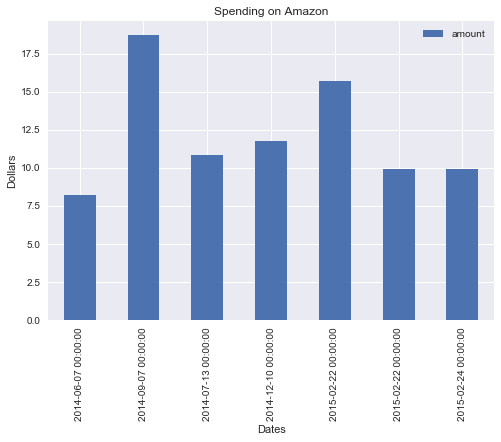

In [11]:
# ignoring the date for now
what="Amazon"

if what in data.Category.values:
    df = data[data.Category.values == what].copy()
    df.amount = df['amount'].apply(abs)
    total_spend = df["amount"].sum()

    # lets tell the user how much was spent on this category
    msg = f"you spent {total_spend} at {what}"
    print(msg)
    #reply(user_id, msg)
    
    # lets plot something
    df.plot.bar(x="date", y="amount")
    #plt.plot(data[data.Category.values == what]["amount"])
    plt.title("Spending on " + what)
    plt.xlabel("Dates"), plt.ylabel("Dollars")

In [12]:
df

,date,description,amount,Category,Subcategory
16,2014-06-07,Amazon Servicesk8662161072 Usd000000000751,8.19,Amazon,None
23,2014-09-07,Amazon Digital Dwnlamazoncom Gbp000000000999,18.70,Amazon,None
41,2014-07-13,Amazon Servicesk8662161072 Usd000000000999,10.87,Amazon,None
298,2014-12-10,Amazon Servicesk8662161072 Usd000000000999,11.73,Amazon,None
624,2015-02-22,Amazon Servicesk8663218851 Usd000000001199,15.67,Amazon,None
625,2015-02-22,Amazon Servicesk8663218851 Usd000000000759,9.92,Amazon,None
632,2015-02-24,Amazon Servicesk8663218851 Usd000000000759,9.92,Amazon,None


In [13]:
# now lets filter for date
d = pd.to_datetime('2015-02-22T00:00:00.000+11:00')
d = pd.to_datetime('2015-01-01T00:00:00.000+0:00')
d

Timestamp('2015-01-01 00:00:00')

In [14]:
date_convert = {"day": "D", "week": "W", "month":"M", "year":"A"}
date_convert

{'day': 'D', 'month': 'M', 'week': 'W', 'year': 'A'}

In [15]:
per = d.to_period("A")
per.start_time, per.end_time

(Timestamp('2015-01-01 00:00:00'), Timestamp('2015-12-31 23:59:59.999999999'))

In [16]:
per

Period('2015', 'A-DEC')

In [17]:
mask = (df.date >= per.start_time) & \
        (df.date <= per.end_time)
df[mask]

,date,description,amount,Category,Subcategory
624,2015-02-22,Amazon Servicesk8663218851 Usd000000001199,15.67,Amazon,None
625,2015-02-22,Amazon Servicesk8663218851 Usd000000000759,9.92,Amazon,None
632,2015-02-24,Amazon Servicesk8663218851 Usd000000000759,9.92,Amazon,None


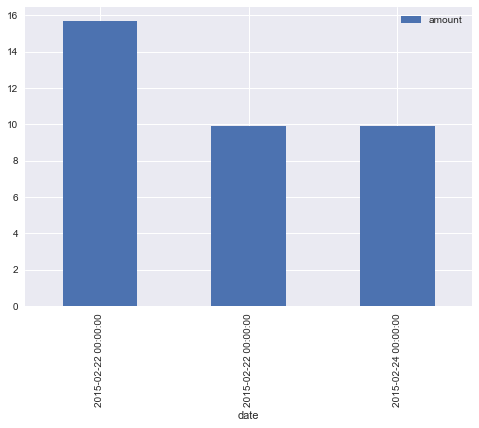

In [18]:
df[mask].plot.bar("date", "amount")

## Final get place info function

In [32]:
query="Officeworks five docks"
country = "Australia"
url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
payload= {"query": query+" "+country, "key": PLACES_API}
r = requests.get(url, params=payload)
r.json()

{'html_attributions': [],
 'results': [{'formatted_address': '213 Parramatta Rd, Five Dock NSW 2046, Australia',
   'geometry': {'location': {'lat': -33.8694755, 'lng': 151.1136929},
    'viewport': {'northeast': {'lat': -33.86832321970849,
      'lng': 151.1149687302915},
     'southwest': {'lat': -33.87102118029149, 'lng': 151.1122707697085}}},
   'icon': 'https://maps.gstatic.com/mapfiles/place_api/icons/shopping-71.png',
   'id': 'dab3d4807be49dc13eb2030b292cccc8c34d0488',
   'name': 'Officeworks Five Dock',
   'opening_hours': {'open_now': True, 'weekday_text': []},
   'photos': [{'height': 1080,
     'html_attributions': ['<a href="https://maps.google.com/maps/contrib/116859293778730537042/photos">Palash Basak</a>'],
     'photo_reference': 'CmRaAAAAagRDT6mePEqkKm9Xmk2OJdt3dnnIqYVXGQNXvBDsRVQfy1Mixkpvdty4IOCqXcldXCj5HpMR1j-WWZJUEtmw4WboYTwczL7b8AtBlyZ2bEtBoO3TlqkpUHPgdKw68fGeEhAnPt_pyLOAGhtJX4D3Fd2jGhQNOVdMm3Qy1L_9Bq-YlbkkuEi3jw',
     'width': 1920}],
   'place_id': 'ChIJbZZA0su

In [31]:
import requests
import csv
places_info = {}

def get_place_info(query="Aldi Broadway", country = "Australia"):
    """takes in a text and returns a google place lookup"""
    
    # return from dict if already looked this up
    if query.lower() in places_info:
        print("returning from dict")
        return places_info[query.lower()]
    
    info = {"address": 0, "location":0, "place_id":0, "types":0}
    
    url = "https://maps.googleapis.com/maps/api/place/textsearch/json"
    payload= {"query": query+" "+country, "key": PLACES_API}
    r = requests.get(url, params=payload)
    
    if r.json()["results"] != []:
        place = r.json()["results"][0]
    else:
        return info
    
    info["address"] = place['formatted_address']
    info["location"] = place['geometry']['location']
    info["place_id"] = place['place_id']
    info["types"] = place['types']
    #info["rating"] = place['types']
    return info  

queries = ["Pablo & Rusty", "rebel sports 2007", "chemist warehouse", "coles broadway"]
places_info = {q.lower(): get_place_info(q) for q in queries}

In [20]:
places_info

{'chemist warehouse': {'address': '4/347-349 William St, Perth WA 6000, Australia',
  'location': {'lat': -31.94540090000001, 'lng': 115.8613471},
  'place_id': 'ChIJZ5FpMtC6MioRzG8Q0Vj2pEI',
  'types': ['pharmacy',
   'health',
   'store',
   'point_of_interest',
   'establishment']},
 'coles broadway': {'address': 'The Broadway Shopping Centre, Broadway St & Bay St, Broadway NSW 2007, Australia',
  'location': {'lat': -33.88365539999999, 'lng': 151.1939585},
  'place_id': 'ChIJk87o1SeuEmsRc2T1HToXOvc',
  'types': ['grocery_or_supermarket',
   'food',
   'store',
   'point_of_interest',
   'establishment']},
 'pablo & rusty': {'address': '161 Castlereagh St, Sydney NSW 2000, Australia',
  'location': {'lat': -33.8723255, 'lng': 151.2090603},
  'place_id': 'ChIJlQzbPT6uEmsRdMutKU9hWds',
  'types': ['cafe', 'food', 'store', 'point_of_interest', 'establishment']},
 'rebel sports 2007': {'address': '44197 Bay Street, Broadway NSW 2007, Australia',
  'location': {'lat': -33.8842421, 'lng':

now to turn this into a df which we can save to a csv file on disk and read from

In [22]:
p = pd.DataFrame.from_dict(places_info, orient="index")
p

,address,location,place_id,types
chemist warehouse,"4/347-349 William St, Perth WA 6000, Australia","{'lat': -31.94540090000001, 'lng': 115.8613471}",ChIJZ5FpMtC6MioRzG8Q0Vj2pEI,"[pharmacy, health, store, point_of_interest, e..."
coles broadway,"The Broadway Shopping Centre, Broadway St & Ba...","{'lat': -33.88365539999999, 'lng': 151.1939585}",ChIJk87o1SeuEmsRc2T1HToXOvc,"[grocery_or_supermarket, food, store, point_of..."
pablo & rusty,"161 Castlereagh St, Sydney NSW 2000, Australia","{'lat': -33.8723255, 'lng': 151.2090603}",ChIJlQzbPT6uEmsRdMutKU9hWds,"[cafe, food, store, point_of_interest, establi..."
rebel sports 2007,"44197 Bay Street, Broadway NSW 2007, Australia","{'lat': -33.8842421, 'lng': 151.194879}",ChIJmdfIvCmuEmsRkjb5rWJlIcU,"[shoe_store, clothing_store, store, point_of_i..."


In [246]:
# now to recreate the original dict
p.to_dict(orient="index")

{'aldiaaaaa': {'address': 0, 'location': 0, 'place_id': 0, 'types': 0},
 'chemist': {'address': 'Chemist, 361A Kensington Rd, Kensington Gardens SA 5068, Australia',
  'location': {'lat': -34.9255225, 'lng': 138.6623479},
  'place_id': 'ChIJubMcjpXLsGoR5FhG6x8Gs3c',
  'types': ['street_address']},
 'coles': {'address': 'Coles SA 5272, Australia',
  'location': {'lat': -37.2497413, 'lng': 140.5150612},
  'place_id': 'ChIJnxbvPGLlymoR66CbSTfRX0A',
  'types': ['locality', 'political']},
 'rebel sports': {'address': 'ANZ Stadium Australia, Edwin Flack Ave, Sydney Olympic Park NSW 2127, Australia',
  'location': {'lat': -33.84709, 'lng': 151.0633958},
  'place_id': 'ChIJe7FPBLOkEmsRVHfNqXxK5tY',
  'types': ['shoe_store',
   'clothing_store',
   'store',
   'point_of_interest',
   'establishment']}}

In [527]:
if "coles" and "rebel sports" in places_info.keys():
    print(4)
t = "s"
if t is not None:
    print(44)
else:
    print(55)

4
44


# strip away un-necessary characters

First lets get all the country codes:

In [239]:
cc = pd.DataFrame.from_csv("data/country-code-to-currency-code-mapping.csv")
cc.head()

,CountryCode,Currency,Code
Country,,,
New Zealand,NZ,New Zealand Dollars,NZD
Cook Islands,CK,New Zealand Dollars,NZD
Niue,NU,New Zealand Dollars,NZD
Pitcairn,PN,New Zealand Dollars,NZD
Tokelau,TK,New Zealand Dollars,NZD


In [241]:
des = 'Woolworths Randwick Aud000000001480'
description = des.split()
" ".join(i for i in description if i[:3].upper() not in cc["Code"].values)

'Woolworths Randwick'